In [1]:
import torch
import pandas as pd
import numpy as np
import os
import pandas as pd
import torchvision
from PIL import Image
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.ops import masks_to_boxes
from torchvision.transforms import v2
import efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [3]:
# if needed
import os
# Windows
os.chdir('D:/')

In [6]:
# set device
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
# load model
model_name = 'efficientnet-b6'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

Loaded pretrained weights for efficientnet-b6


In [5]:
#change model input
from efficientnet_pytorch.utils import Conv2dStaticSamePadding
model._conv_stem = Conv2dStaticSamePadding(1, 56, kernel_size=(3, 3), stride=(2, 2), image_size = 490, bias=False)

In [21]:
# move model to device
model = model.to(device)

In [8]:
# make augmentation
transform_gpu =  v2.Compose([
    v2.RandomRotation(360),
    v2.RandomHorizontalFlip(),
])

In [9]:
# you can calculate it in get_mean_and_std.py code
mean_train, std_train = 0.25, 0.09

In [11]:
# make class CustomImageDataset
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, mask_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = self.img_labels.iloc[idx]['class']
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx]['file name'])
        mask_path = os.path.join(self.img_dir, self.img_labels.iloc[idx]['mask name'])

        image =  Image.open(img_path)
        image = np.array(image)/65535
        image = (image - mean_train)/std_train
        image_torch = torch.from_numpy(image)
        image_torch = image_torch.unsqueeze(0)

        masks = np.load(mask_path)
        mask = np.ma.masked_values(masks, self.img_labels.iloc[idx]['mask number']).mask
        torch_mask = torch.unsqueeze(torch.from_numpy(mask), 0)
        boxes = masks_to_boxes(torch_mask)

        mean_x = int((boxes[0][0]+boxes[0][2])/2)
        mean_y = int((boxes[0][1]+boxes[0][3])/2)

        len_x = int((-boxes[0][0]+boxes[0][2]))
        len_y = int((-boxes[0][1]+boxes[0][3]))
        
        masked_cell = (image*mask)

        box_cell = torch.from_numpy(masked_cell[int(boxes[0][1]):int(boxes[0][3]), 
                                        int(boxes[0][0]):int(boxes[0][2])])

        box_size_x = int(-boxes[0][0])+int(boxes[0][2])
        box_size_y = int(-boxes[0][1])+int(boxes[0][3])

        x_size, y_size = 410, 410

        if box_size_x>x_size:
            box_cell = box_cell[:, box_size_x//2 - x_size//2: box_size_x//2+(x_size-x_size//2)]
            box_size_y, box_size_x= box_cell.shape[0], box_cell.shape[1]
        if box_size_y>y_size:
            box_cell = box_cell[box_size_y//2 - y_size//2: box_size_y//2+(y_size-y_size//2), :]
            box_size_y, box_size_x = box_cell.shape[0], box_cell.shape[1]

        final_image = torch.zeros((x_size, y_size))
        final_image[y_size//2-box_size_y//2: y_size//2+(box_size_y-box_size_y//2),
                      x_size//2-box_size_x//2: x_size//2+(box_size_x-box_size_x//2)] = box_cell
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return final_image.unsqueeze(0), label

In [12]:
# make datasets
train_set = CustomImageDataset('new_train_set.csv', '', '')
test_set = CustomImageDataset('new_test_set.csv', '', '')

In [15]:
# use it if you want visualize training process
class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))
  
  def display(self,groups = None): 
    # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
    clear_output()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys) 
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

In [ ]:
# Windows
from tqdm.notebook import tqdm
# Linux
# from tqdm import tqdm

# set parameters
batch_size = 32
num_epochs = 10

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# step_lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9) # you can use scheduler if needed

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

model.train()

pp = ProgressPlotter()
# training model
for epoch in range(num_epochs):

    for i, data in tqdm(enumerate(train_loader)):
        running_loss = 0.0
        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = transform_gpu(inputs)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs.squeeze(), labels.float().squeeze())
        loss.backward()
        optimizer.step()
        step_lr.step()

        running_loss += loss.item()
        
        pp.add_scalar('loss_train', running_loss)
        pp.display([['loss_train']])
        print(f"Batch {i} in Epoch {epoch} end!")

In [ ]:
# save our model and state_dict
torch.save(model, 'EfficientNetB6_490')
torch.save(model.state_dict(), 'EfficientNetB6_490_state_dict')

In [40]:
val_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=32, shuffle=False)

In [ ]:
from sklearn.metrics import classification_report 
model.eval()

# Evaluate the model on the validation set
predictions = []
true_labels = []
probs = []

with torch.no_grad():
    for images, labels in val_loader:
        # Move images and labels to the device (e.g., GPU) if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        prob = torch.sigmoid(outputs)  # Проекция сигмоидой
        pred = (prob > 0.5).float()

        # Accumulate predictions and true labels
        predictions.extend(pred.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        probs.extend(prob.cpu().numpy())

# Calculate classification report
report = classification_report(true_labels, predictions)

# Print the classification report
print(report)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(true_labels, probs)
accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(accuracy_score(true_labels, [m > thresh for m in probs]))

accuracies = np.array(accuracy_scores)
max_accuracy = accuracies.max() 
max_accuracy_threshold =  thresholds[accuracies.argmax()]
print(max_accuracy)
print(max_accuracy_threshold)

In [53]:
best_pred = []
for prob in probs:
    pred = (prob > max_accuracy_threshold)
    best_pred.extend(pred)

In [ ]:
report = classification_report(true_labels, best_pred)

# Print the classification report
print(report)

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

probs = np.array(probs)
lables = np.array(true_labels) 

# ROC-AUC calculation
fpr, tpr, thresholds = roc_curve(labels, predictions)
roc_auc = roc_auc_score(labels, predictions)

# visualize
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

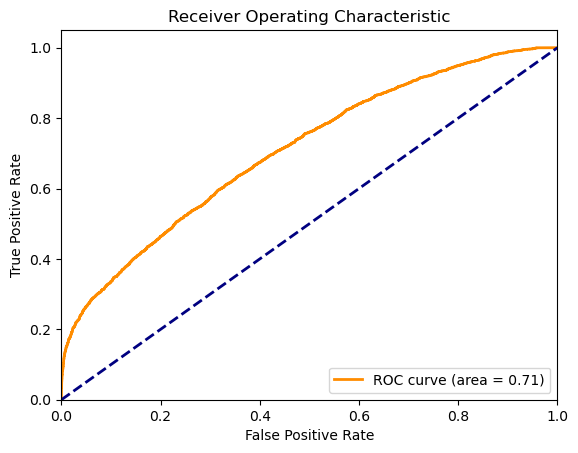

In [56]:
probs = np.array(probes)
lables = np.array(true_labels) 

# Расчет кривой ROC-AUC
fpr, tpr, thresholds = roc_curve(lables, probs)
roc_auc = roc_auc_score(lables, probs)

# Вывод графика кривой ROC-AUC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()